In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.subplots import make_subplots
import plotly.express as px

import missingno as msno

In [3]:
!pip install missingno

Defaulting to user installation because normal site-packages is not writeable


In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

from sklearn import metrics


In [5]:
# LOADING THE DATA 
df = pd.read_csv('insurance.csv')

# 1. Understand the Data

In [6]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### The Dataset gives general information like:**
* There are lots of factors that cause for paying insurance ,Here are some factors that directly cause health insurance.
* **Age :**  Main fector 
* **Sex :** Insurance Contarctor gender : male , female
* **bmi :** Body mass index , shows a understanding of body , **idealy <BMI> 18 to 25** 
* **Children :** No of children covered in Insurance
* **Smoker :** is/not
* **Region :** Region wise benifiecery like Mumbai , delhi Kolkata , Banglore .

In [7]:
print('Number of rows and columns in the data set: ',df.shape)

Number of rows and columns in the data set:  (1338, 7)


In [8]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [9]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


<Figure size 500x200 with 0 Axes>

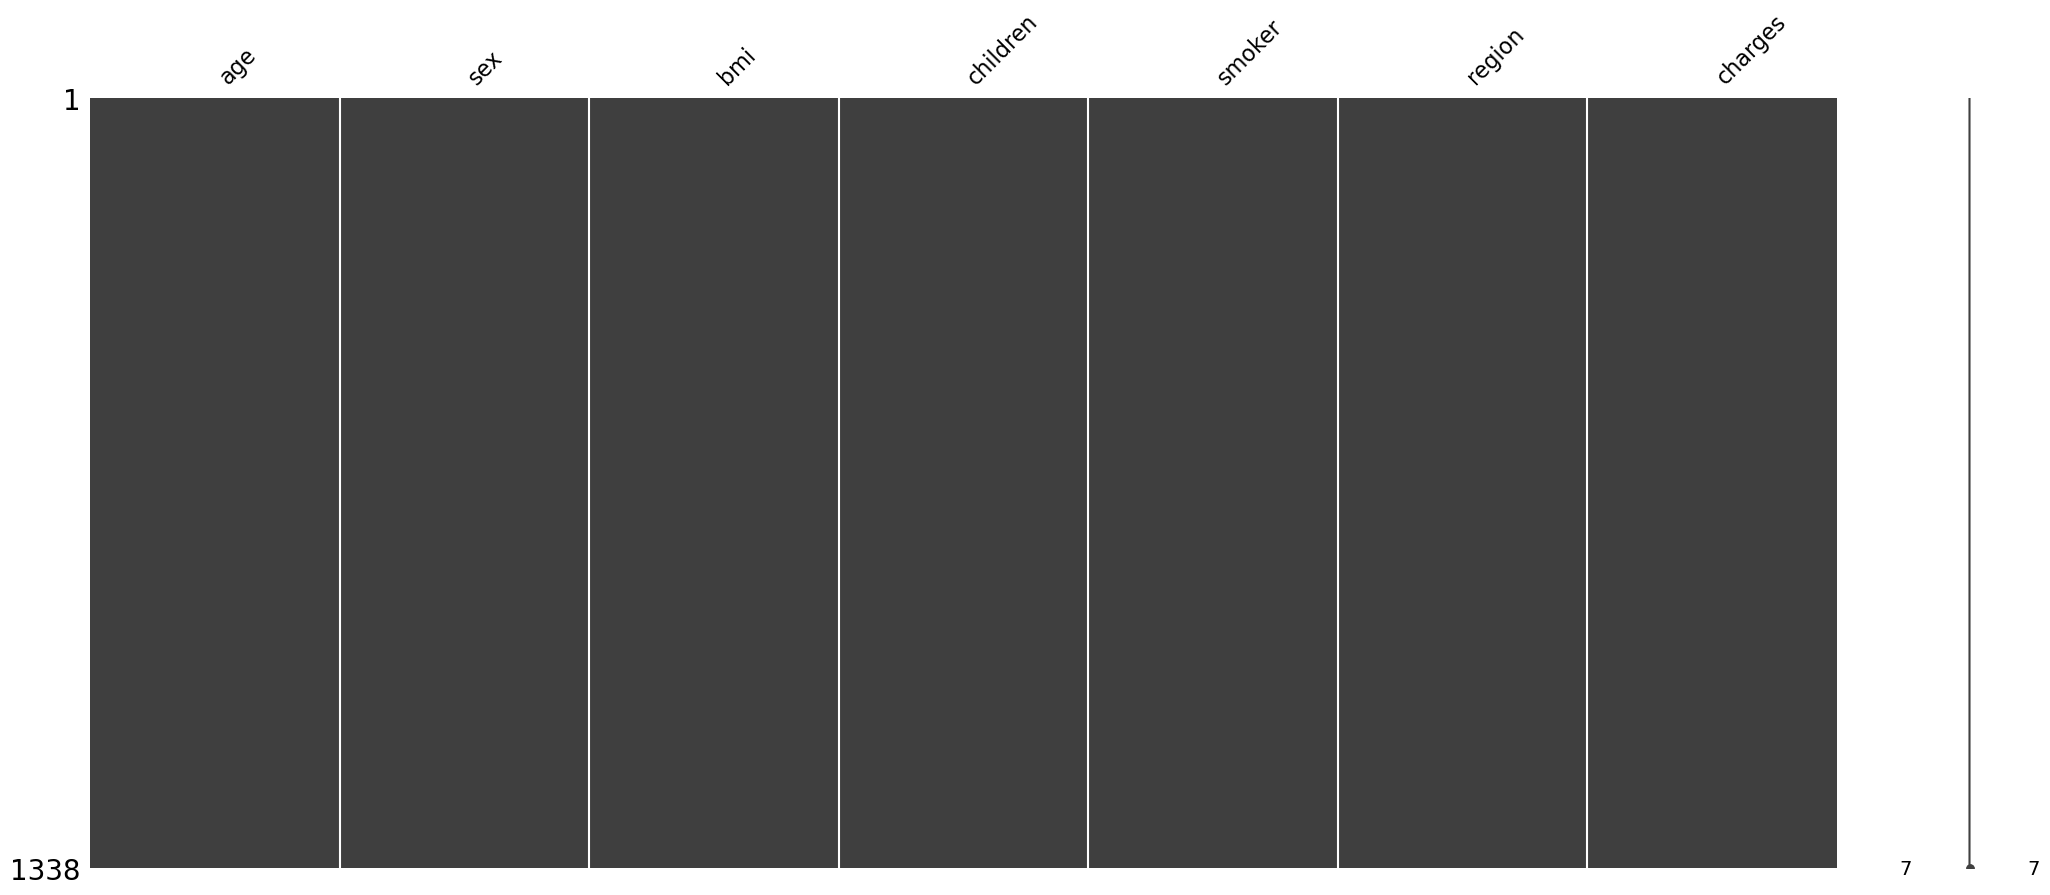

In [10]:
plt.figure(figsize=(5,2))
msno.matrix(df)
plt.show()

* We have 0 missing values which is very good. Now let's do EDA  First 

## 2 Visualization to Understand Data

***Corelation Btwn data***

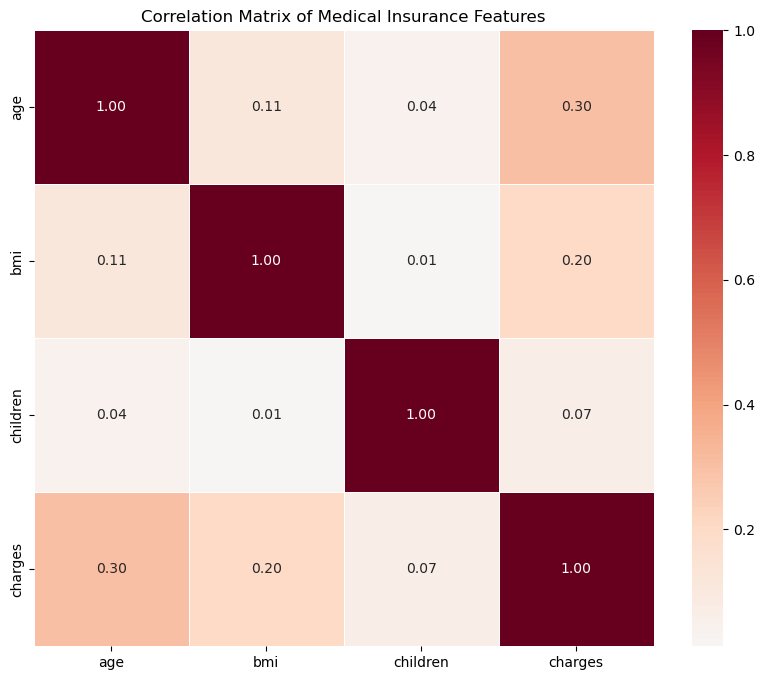

In [11]:

plt.figure(figsize=(10, 8))
corr = df.corr(numeric_only=True) # numeric_only avoids errors with text columns

sns.heatmap(corr, 
            annot=True, 
            fmt=".2f", 
            cmap='RdBu_r', 
            center=0,
            linewidths=0.5)

plt.title('Correlation Matrix of Medical Insurance Features')
plt.show()

* There is no Co-relation among variables . Its hard But lets check by one 

**Check Distribution Of Charges**

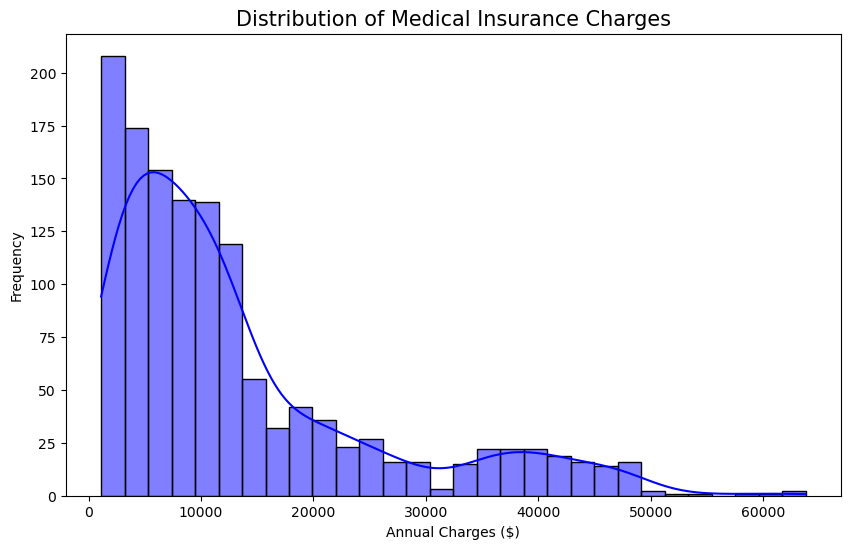

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(df['charges'], kde=True, color='blue', bins=30)

plt.title('Distribution of Medical Insurance Charges', fontsize=15)
plt.xlabel('Annual Charges ($)')
plt.ylabel('Frequency')
plt.show()

**If we look at the  plot the charges varies from 1000 to 60000, the plot is right skewed**

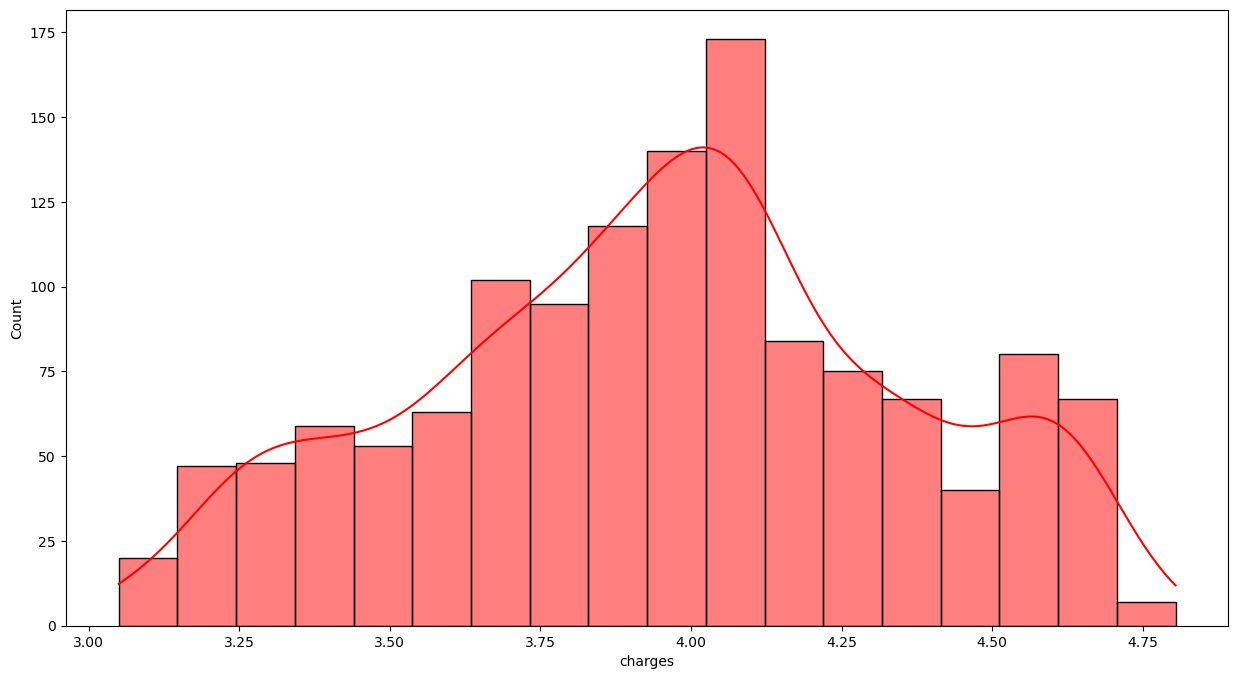

In [13]:
f, ax = plt.subplots(1, 1, figsize=(15, 8))
ax = sns.histplot(np.log10(df['charges']), kde = True, color = 'r' )
plt.show()

The 'Charges' data is likey very skewed . (Most people are very small amount few paying a lot) 
* The tallest peak  is around (4.0) The most common medical cost 
* the lowest peak is around (3.1) , lowest medical cost.

In [14]:
df.head(2)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523


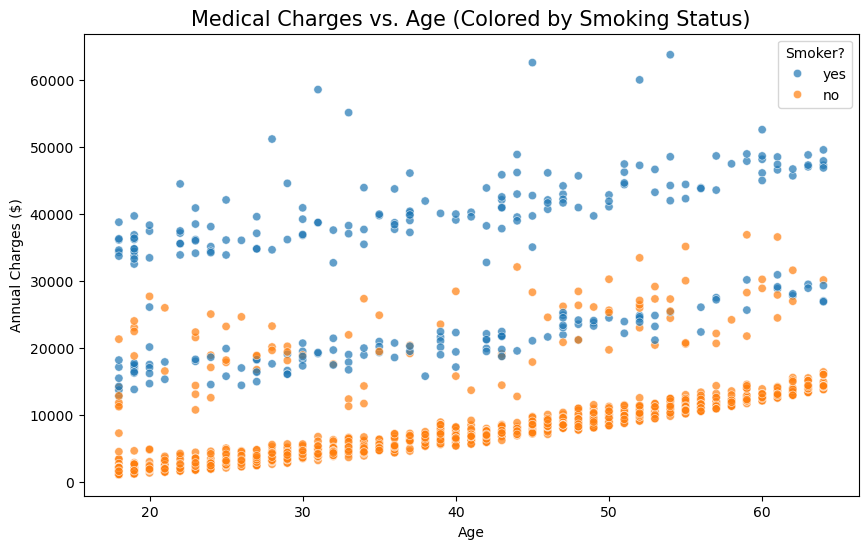

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='charges', data=df, hue='smoker', alpha=0.7)

plt.title('Medical Charges vs. Age (Colored by Smoking Status)', fontsize=15)
plt.xlabel('Age')
plt.ylabel('Annual Charges ($)')
plt.legend(title='Smoker?')
plt.show()

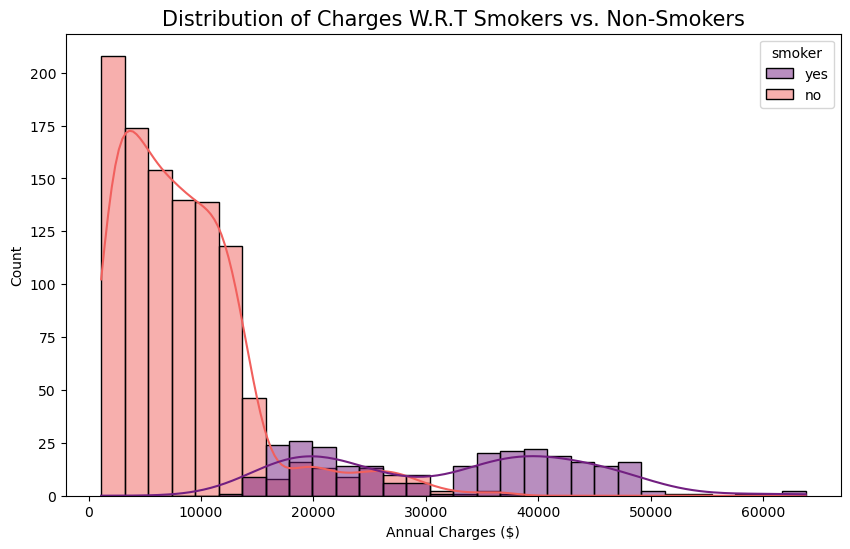

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='charges', hue='smoker', kde=True, palette='magma', bins=30)

plt.title('Distribution of Charges W.R.T Smokers vs. Non-Smokers', fontsize=15)
plt.xlabel('Annual Charges ($)')
plt.show()

* Notice that the "Non-Smoker" distribution ends almost exactly where the "Smoker" distribution begins. This proves smoker is a linearly separable feature.
* The non-smoker group is very "tight" , while the smoker group is  spread out (high variance).

**Smoking patients spend more on treatment. But there are  number of non-smoking patients is greater. Going to check it.**



In [17]:
age_18 = df[df['age'] == 18]                                                                           # Filter for only 18-year-olds

avg_costs = age_18.groupby('smoker')['charges'].mean()

print("Average Charges for 18-year-old:")
print(f"Non-Smokers: ${avg_costs['no']}")
print(f"Smokers:     ${avg_costs['yes']}")

# Calculate the 'Smoker Tax' multiplier
multiplier = avg_costs['yes'] / avg_costs['no']
print(f"\nSmokers at age 18 pay {multiplier:.1f}x more than non-smokers.")

Average Charges for 18-year-old:
Non-Smokers: $3215.1622585789473
Smokers:     $25473.73022083333

Smokers at age 18 pay 7.9x more than non-smokers.


C:\Users\hp\AppData\Local\Temp\ipykernel_12984\1744564086.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='sex', y='charges', palette=['#FF5733', '#33FF57'])


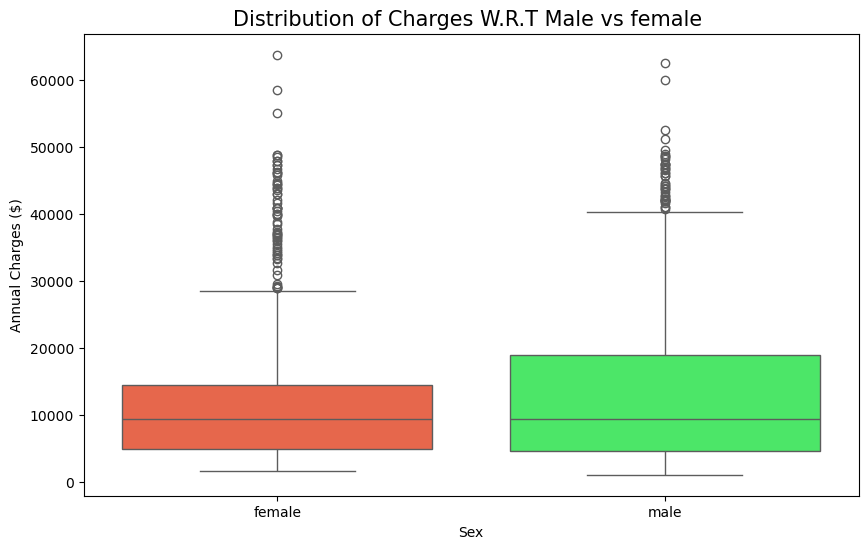

In [18]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='sex', y='charges', palette=['#FF5733', '#33FF57'])

plt.title('Distribution of Charges W.R.T Male vs female ', fontsize=15)
plt.ylabel('Annual Charges ($)')
plt.xlabel('Sex')

plt.show()

***The median Line  is at similar level for both males and females , its show
 avg charges are same for male and female.***
* MALE ARE  slighter wider range in cots in dataset
* black circle are paying more than the average .

***Sex is not Not  a factor of high charges***

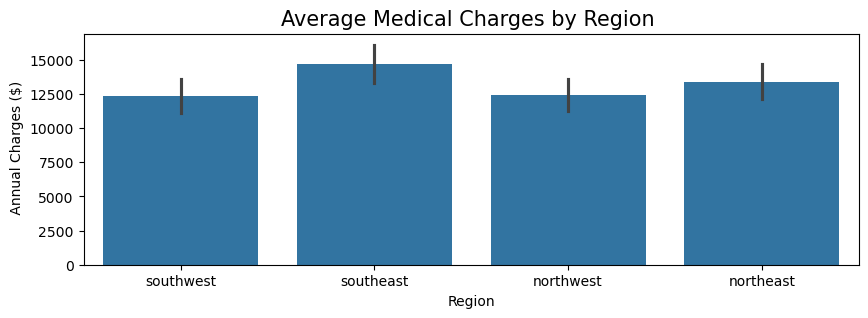

In [19]:
plt.figure(figsize=(10, 3))
sns.barplot(x='region', y='charges', data=df )

plt.title('Average Medical Charges by Region ', fontsize=15)
plt.xlabel('Region')
plt.ylabel(' Annual Charges ($)')
plt.show()

So overall the highest medical charges are in the Southeast and the lowest are in the Southwest. Taking into account certain factors  let's see how it changes by region

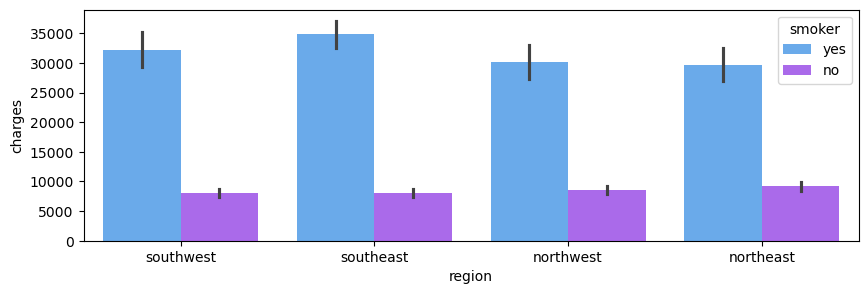

In [20]:
f, ax = plt.subplots(1, 1, figsize=(10, 3))
ax = sns.barplot(x='region', y='charges', hue='smoker', data=df, palette='cool')
plt.show()

* Region not effect on smoking or not.
* Charges are also not vary w.r.t city . 
* A little jump in southwest

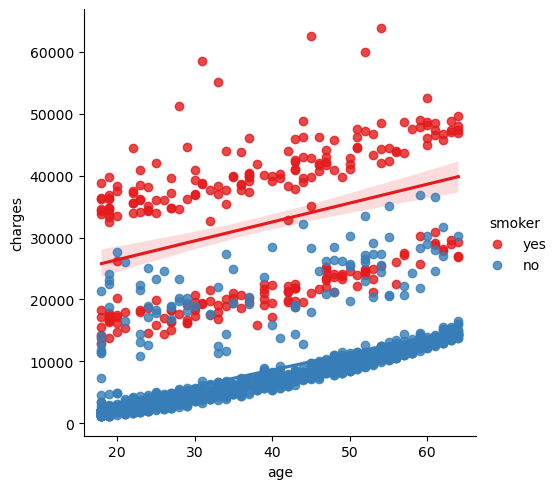

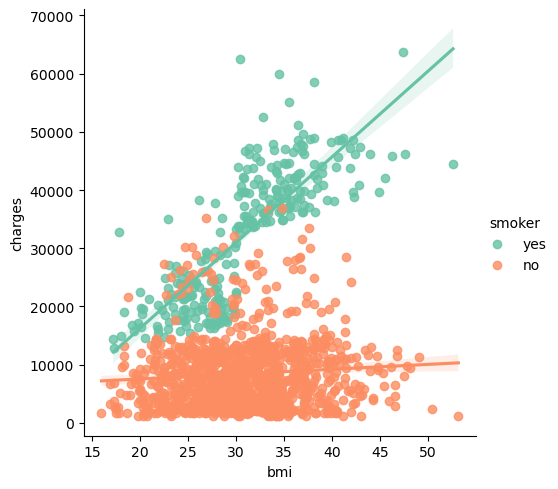

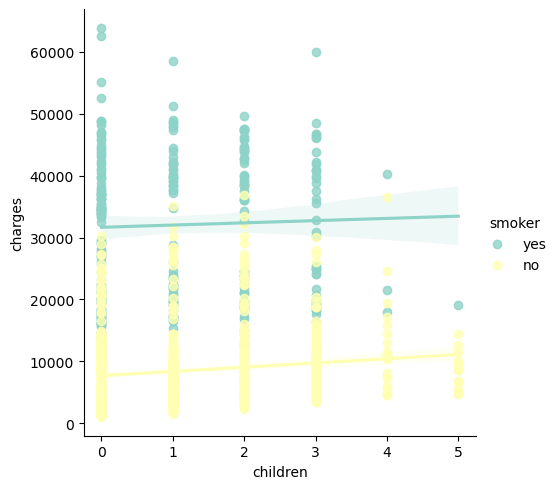

In [21]:
ax = sns.lmplot(x = 'age', y = 'charges', data=df, hue='smoker', palette='Set1')
ax = sns.lmplot(x = 'bmi', y = 'charges', data=df, hue='smoker', palette='Set2')
ax = sns.lmplot(x = 'children', y = 'charges', data=df, hue='smoker', palette='Set3')
plt.show()

**1-> plot 1  ,2-> plot->2 , 3 Plot->3**
* 1. In this people who smoke less are playing less charges | w.r.t age increses more paying

* 2. In this bmi is factor of high Charges 

* 3. children are  not smoking .